In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
TBI_Pos = '/content/drive/MyDrive/TBI-Pos'
TBI_Neg = '/content/drive/MyDrive/TBI-Neg'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from torch.utils.data import ConcatDataset

In [ ]:
seed_value = 1234


torch.manual_seed(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



In [ ]:
unique_columns = set()
for file_name in os.listdir(TBI_Neg):
  if file_name.endswith('.csv'):
    df = pd.read_csv(os.path.join(TBI_Neg, file_name))
    unique_columns.update(set(df.columns))
for file_name in os.listdir(TBI_Pos):
  if file_name.endswith('.csv'):
    df = pd.read_csv(os.path.join(TBI_Pos, file_name))
    unique_columns.update(set(df.columns))


# Convert the set to a list and print the column names
column_names = list(unique_columns)
print(column_names)


['s.225', 's.190', 's208', 's290', 's62', 's.49', 's.10', 's.64', 's225', 's.128', 's.36', 's.96', 's.94', 's.199', 's.227', 's.290', 's46', 's075', 's073', 's034', 's.24', 's.32', 's.13', 's73', 's.146', 's.18', 's.26', 's124', 's062', 's.7', 's.267', 's42', 's.17', 's.272', 's.133', 's198', 's.183', 's008', 's41', 's.144', 's.240', 's074', 's229', 's35', 's.100', 's.62', 's.53', 's.103', 's96', 's071', 's098', 's.226', 's.109', 's18', 's.50', 's.231', 's.196', 's.51', 's285', 's.20', 's.219', 's.194', 's135', 's57', 's027', 's272', 's065', 's.224', 's.220', 's.277', 's82', 's218', 's.130', 's26', 's40', 's.155', 's014', 's95', 's.41', 's29', 's.209', 's.237', 's194', 's80', 's.188', 's270', 's233', 's66', 's74', 's009', 's057', 's125', 's282', 's.214', 's172', 's127', 's.4', 's166', 's148', 's89', 's.73', 's.12', 's.284', 's32', 's279', 's.116', 's219', 's033', 's.238', 's101', 's261', 's196', 's024', 's.235', 's.212', 's.232', 's182', 's.262', 's.293', 's.5', 's77', 's109', 's.180',

In [ ]:
class CSVDataset(Dataset):
    def __init__(self, folder_path, label):
        self.data = []
        self.label = label
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.csv'):
                # Load CSV file into pandas DataFrame
                df = pd.read_csv(os.path.join(folder_path, file_name))
                # Convert DataFrame to numpy array
                data = df.to_numpy()
                # Scale the data using StandardScaler
                scaler = StandardScaler()
                data = scaler.fit_transform(data)
                # Convert numpy array to a PyTorch tensor
                data = torch.from_numpy(data).float()
                # Append data and label to self.data list
                self.data.append((data, label))
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
neg_label = 0
pos_label = 1

# Define train and test datasets for tbi-neg folder
neg_dataset = CSVDataset(TBI_Neg, neg_label)
neg_train_dataset, neg_test_dataset = torch.utils.data.random_split(neg_dataset, [int(0.8*len(neg_dataset)), len(neg_dataset)-int(0.8*len(neg_dataset))])

# Define train and test datasets for tbi-pos folder
pos_dataset = CSVDataset(TBI_Pos, pos_label)
pos_train_dataset, pos_test_dataset = torch.utils.data.random_split(pos_dataset, [int(0.8*len(pos_dataset)), len(pos_dataset)-int(0.8*len(pos_dataset))])

# Merge train and test datasets for tbi-neg and tbi-pos folders
train_dataset = ConcatDataset([neg_train_dataset, pos_train_dataset])
test_dataset = ConcatDataset([neg_test_dataset, pos_test_dataset])
print('training data set:',len(train_dataset))
print('testing data set:',len(test_dataset))

training data set: 28
testing data set: 8


In [ ]:
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        #out = self.dropout(out)
        
        out = self.fc(out[:, -1, :])
        
        return out

In [ ]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
# Define hyperparameters
input_size = train_dataset[0][0].shape[1]
hidden_size = 64
num_layers = 2
output_size = 1
batch_size = 1
learning_rate = 0.001
num_epochs = 10

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
for i, batch in enumerate(train_loader):
    data, labels = batch
    
    print(f"Batch {i+1} data shape: {data.shape}")
    print(f"Batch {i+1} labels shape: {labels.shape}")

Batch 1 data shape: torch.Size([1, 375, 294])
Batch 1 labels shape: torch.Size([1])
Batch 2 data shape: torch.Size([1, 375, 294])
Batch 2 labels shape: torch.Size([1])
Batch 3 data shape: torch.Size([1, 375, 294])
Batch 3 labels shape: torch.Size([1])
Batch 4 data shape: torch.Size([1, 375, 294])
Batch 4 labels shape: torch.Size([1])
Batch 5 data shape: torch.Size([1, 375, 294])
Batch 5 labels shape: torch.Size([1])
Batch 6 data shape: torch.Size([1, 375, 294])
Batch 6 labels shape: torch.Size([1])
Batch 7 data shape: torch.Size([1, 375, 294])
Batch 7 labels shape: torch.Size([1])
Batch 8 data shape: torch.Size([1, 375, 294])
Batch 8 labels shape: torch.Size([1])
Batch 9 data shape: torch.Size([1, 375, 294])
Batch 9 labels shape: torch.Size([1])
Batch 10 data shape: torch.Size([1, 375, 294])
Batch 10 labels shape: torch.Size([1])
Batch 11 data shape: torch.Size([1, 375, 294])
Batch 11 labels shape: torch.Size([1])
Batch 12 data shape: torch.Size([1, 375, 294])
Batch 12 labels shape: to

In [ ]:
import torch.nn.functional as F
from sklearn.metrics import f1_score, confusion_matrix, mean_squared_error
import seaborn as sns

In [ ]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []


In [ ]:

model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training the LSTM model
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        predicted = torch.round(torch.sigmoid(outputs))
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()
    train_accuracy = 100 * correct / total
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    #print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
    print('Epoch [{}/{}], Train Loss: {:.4f}'
          .format(epoch+1, num_epochs, train_loss))




Epoch [1/10], Train Loss: 0.7071
Epoch [2/10], Train Loss: 0.5444
Epoch [3/10], Train Loss: 0.2158
Epoch [4/10], Train Loss: 0.0416
Epoch [5/10], Train Loss: 0.0181
Epoch [6/10], Train Loss: 0.0104
Epoch [7/10], Train Loss: 0.0073
Epoch [8/10], Train Loss: 0.0055
Epoch [9/10], Train Loss: 0.0043
Epoch [10/10], Train Loss: 0.0035


In [ ]:
# Testing LSTM model
model.eval()
test_loss=0
y_true = []
y_pred = []
feature_importances = {}

with torch.no_grad():
    correct = 0
    total = 0
    test_loss = 0
    
    for inputs, labels in test_loader:

      inputs = inputs.float().to(device)
      labels = labels.float().to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels.unsqueeze(1))
      test_loss += loss.item() * inputs.size(0)
      predicted = torch.round(torch.sigmoid(outputs))
      total += labels.size(0)
      correct += (predicted == labels.unsqueeze(1)).sum().item()
      y_true.extend(labels.cpu().numpy())
      y_pred.extend(predicted.cpu().numpy())

    test_accuracy = 100 * correct / total
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)


    print('Test Loss: {:.4f}, Test Acc: {:.2f}%'
            .format(test_loss, test_accuracy))
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    

      
    
    print('F1 Score: {:.4f}'.format(f1))
    print('Confusion Matrix:')
    print(cm)





Test Loss: 0.7814, Test Acc: 75.00%
F1 Score: 0.7500
Confusion Matrix:
[[3 1]
 [1 3]]


In [ ]:
test_error_rate = 1 - (correct / total)
print('test error rate is', test_error_rate)

test error rate is 0.25


In [ ]:
import matplotlib.pyplot as plt

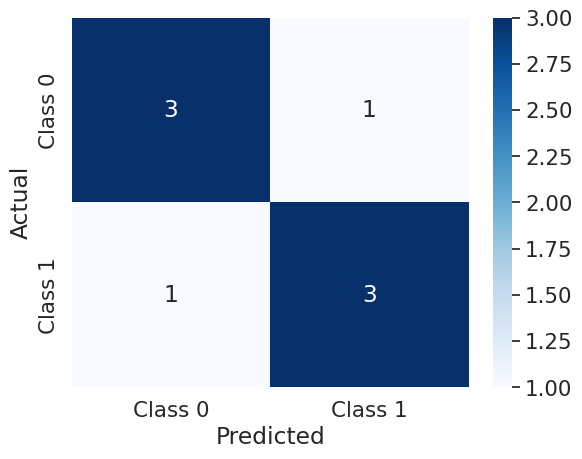

In [ ]:
sns.set(font_scale=1.4) # Adjust the font size
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()





In [ ]:
from sklearn.metrics import classification_report

              precision    recall  f1-score   support

         0.0       0.75      0.75      0.75         4
         1.0       0.75      0.75      0.75         4

    accuracy                           0.75         8
   macro avg       0.75      0.75      0.75         8
weighted avg       0.75      0.75      0.75         8



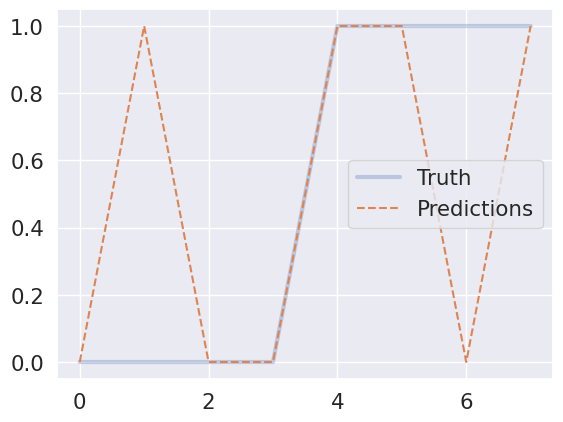

In [ ]:
plt.plot(y_true, lw=3, alpha=0.3, label='Truth')
plt.plot(y_pred, '--', label='Predictions')
plt.legend(loc='best')
print(classification_report(y_true, y_pred))


In [ ]:
df = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred})
print(df.head(10))

   Actual Predicted
0     0.0     [0.0]
1     0.0     [1.0]
2     0.0     [0.0]
3     0.0     [0.0]
4     1.0     [1.0]
5     1.0     [1.0]
6     1.0     [0.0]
7     1.0     [1.0]


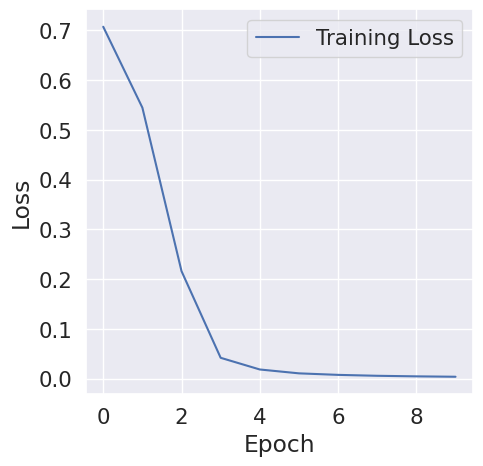

In [ ]:


plt.figure(figsize=(5, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
df= pd.read_csv('/content/drive/MyDrive/205-DOD-tts_all.csv')

In [ ]:

data_tensor = torch.tensor(df.values).float().unsqueeze(0)
input_size = df.shape[1]  # number of features in your input data
hidden_size = 64
num_layers = 2
output_size = 1
model.eval()
output = model(data_tensor)
predictions = torch.round(torch.sigmoid(output)).squeeze().tolist()
if(predictions == 0):
  print('TBI-Neg')
else:
  print('TBI-Pos')






TBI-Neg


In [ ]:
data_pos = pd.read_csv('/content/drive/MyDrive/103-DOD-tts_all.csv')

In [ ]:
data_tensor = torch.tensor(data_pos.values).float().unsqueeze(0)
input_size = df.shape[1]  # number of features in your input data
hidden_size = 64
num_layers = 2
output_size = 1
model.eval()
output = model(data_tensor)
predictions = torch.round(torch.sigmoid(output)).squeeze().tolist()
if(predictions == 0):
  print('TBI-Neg')
else:
  print('TBI-Pos')


TBI-Pos


In [ ]:
from sklearn.metrics import roc_curve, auc


In [ ]:

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

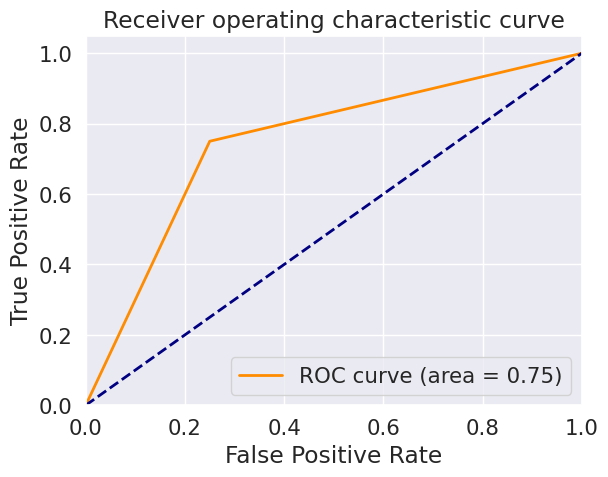

In [ ]:
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:

df = pd.read_csv('/content/drive/MyDrive/103-DOD-tts_all.csv')


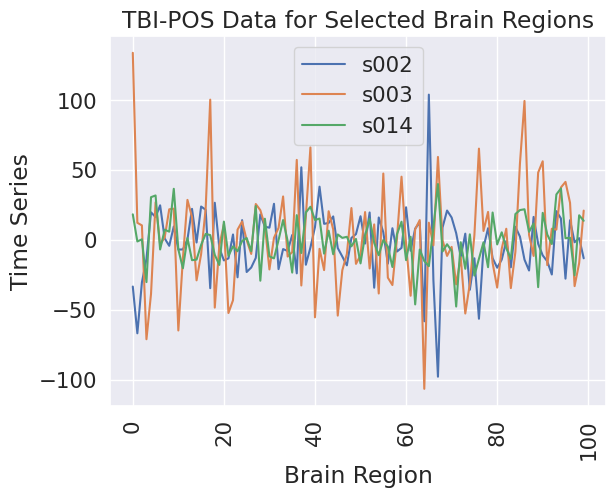

In [ ]:
df = df.T
selected_regions = [ 's002', 's003','s014']
df[selected_regions].iloc[:100].plot()
plt.xticks(rotation=90)
plt.xlabel('Brain Region')
plt.ylabel('Time Series')
plt.title('TBI-POS Data for Selected Brain Regions')
plt.show()

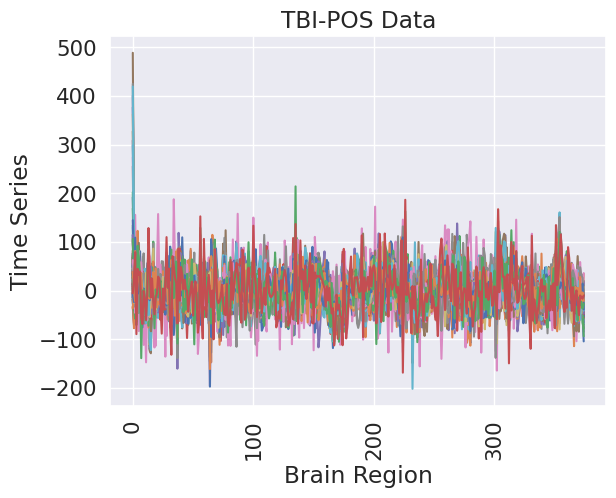

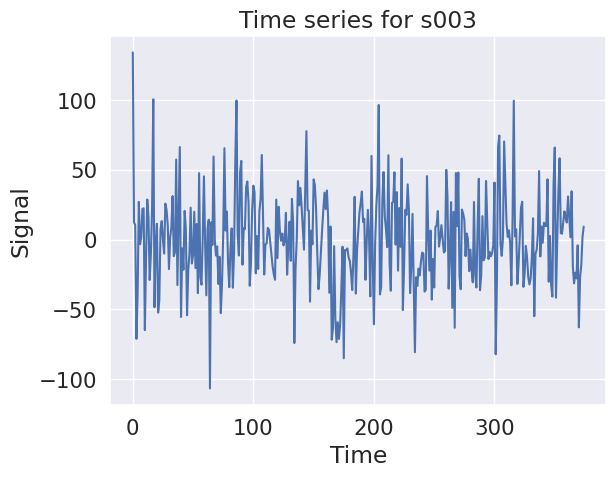

In [ ]:
# data as a line plot for all regions
df = df.T

# Plot line plot
plt.plot(df)
plt.xticks(rotation=90)
plt.xlabel('Brain Region')
plt.ylabel('Time Series')
plt.title('TBI-POS Data')
plt.show()

region = 's003' # replace with your desired brain region name
region_data = df[region]

# plot the region data against time series
plt.plot(region_data)
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Time series for {}'.format(region))
plt.show()


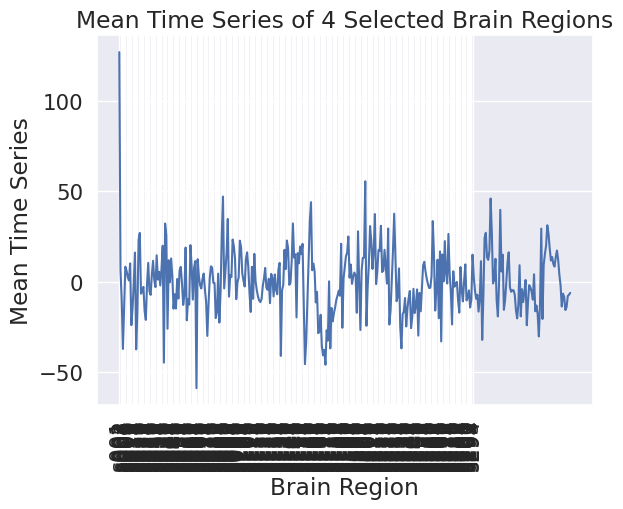

In [ ]:
regions = ['s002', 's003', 's004', 's005']
mean = data_pos[regions].mean(axis=1)
plt.plot(mean)
plt.xticks(range(len(data_pos.columns)), data_pos.columns, rotation=90)
plt.xlabel('Brain Region')
plt.ylabel('Mean Time Series')
plt.title('Mean Time Series of 4 Selected Brain Regions')
plt.show()




Text(0.5, 1.0, 'Mean Value of Selected Brain Regions')

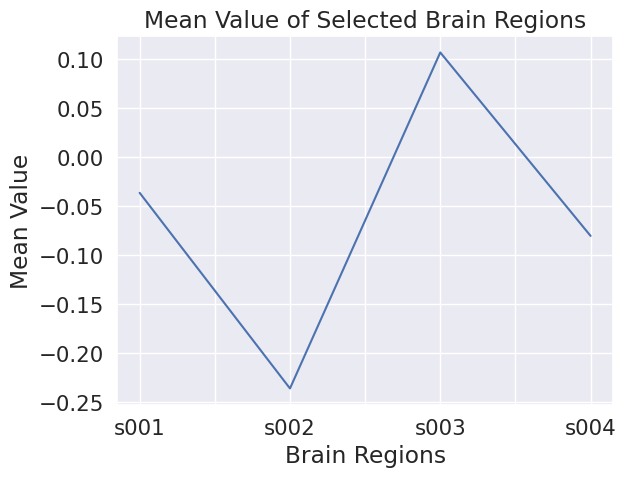

In [ ]:
regions = ['s001', 's002', 's003', 's004']
mean_values = df[regions].mean()
mean_values.plot(kind='line')
plt.xlabel('Brain Regions')
plt.ylabel('Mean Value')
plt.title('Mean Value of Selected Brain Regions')







In [ ]:
#extract brain regions
!pip install captum
from captum.attr import IntegratedGradients

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.1 MB/s eta 0:00:00


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 20.5 MB/s eta 0:00:00


In [ ]:

import shap


In [ ]:
torch.save(model.state_dict(), 'Savinglstm_model.pth')

In [ ]:
import lime
import lime.lime_tabular

In [ ]:
model.load_state_dict(torch.load('Savinglstm_model.pth'))

<All keys matched successfully>

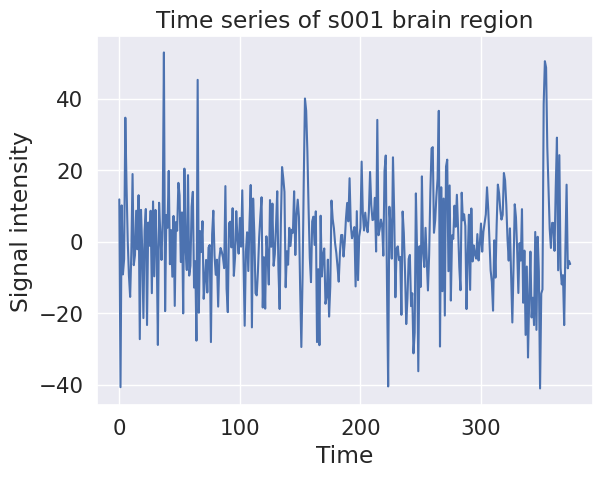

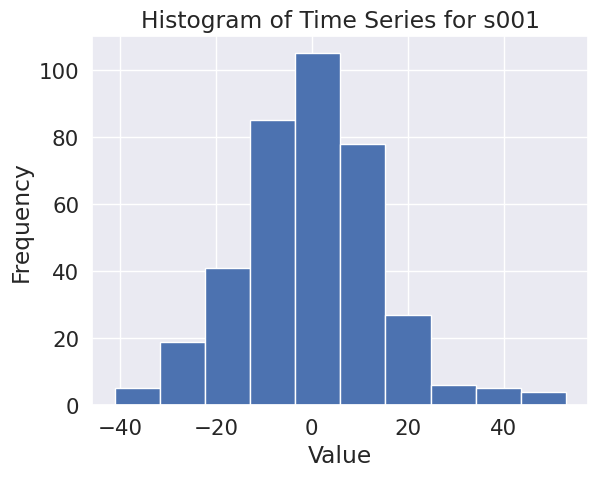

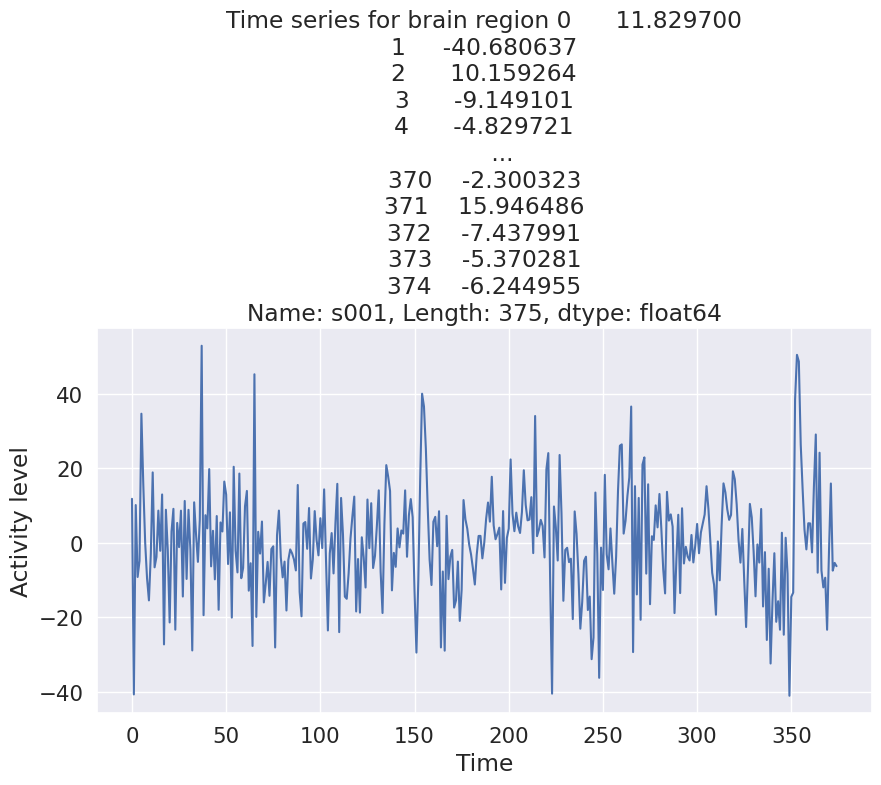

In [ ]:
# Load the data
data = pd.read_csv('/content/drive/MyDrive/103-DOD-tts_all.csv')

brain_region = 's001'
time_series = data[brain_region]

s001 = data['s001']

# Plot the time series
plt.plot(s001)
plt.title('Time series of s001 brain region')
plt.xlabel('Time')
plt.ylabel('Signal intensity')
plt.show()


# Plot the histogram
plt.hist(time_series, bins=10)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Time Series for ' + brain_region)
plt.show()

 # Plot the time series
plt.figure(figsize=(10,5))
plt.plot(range(len(s001)), s001)
plt.xlabel('Time')
plt.ylabel('Activity level')
plt.title('Time series for brain region {}'.format(s001))
plt.show()